In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
df_all = pd.read_csv("48_features.csv", header=0, encoding="utf-8").drop(["Unnamed: 0"], axis=1)
df_all.fillna(0, inplace=True)
df_all = df_all.astype("int32")
df_2 = pd.DataFrame(columns=df_all.columns)

for index, row in df_all.iterrows():
    if row["award_id"] in [2, 3]:
        df_2 = df_2.append(row, ignore_index=True)

df_2.fillna(0, inplace=True)
df_2 = df_2.astype("int32")

In [3]:
def data_to_read(name):
    return eval(name)

df = data_to_read("df_2")

df_labels = df["award_id"]
df_user_id = df["user_id"]

df.drop(columns=["award_id", "user_id"], axis=1, inplace=True)

In [4]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
# from xgboost.sklearn import XGBClassifier
import gc
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, mean_squared_error, zero_one_loss

In [5]:
num_round = 1000

data = df.copy()

## category feature one_hot
cate_feature = df.columns
for item in cate_feature:
    data[item] = LabelEncoder().fit_transform(data[item])
    item_dummies = pd.get_dummies(data[item])
    item_dummies.columns = [item + str(i + 1) for i in range(item_dummies.shape[1])]
    data = pd.concat([data, item_dummies], axis=1)
data.drop(cate_feature,axis=1,inplace=True)

data_y = df_labels.factorize()[0]

In [189]:
import random

In [198]:
# train_x, test_x, train_y, test_y = train_test_split(data, data_y, test_size=0.1, random_state=100)

train_x, test_x, train_y, test_y = train_test_split(data, data_y, test_size=0.1, random_state=random.randint(1, 200))

In [12]:
dtrain = xgb.DMatrix(data=train_x, label=train_y, missing=-999.0)
dtest = xgb.DMatrix(data=test_x, label=test_y, missing=-999.0)

### 构建模型

In [29]:
import hyperopt
from hyperopt import fmin, tpe, hp, partial, STATUS_OK, Trials
import warnings

label_size not match error is because of the additional num_class

In [25]:
model = xgb.XGBClassifier(  
                            n_estimators = 100,
                            max_depth = 5,
                            learning_rate = 0.01,
                            gamma = 0.5,
                            min_child_weight = 0.1,
                            subsample = 0.5,
                            colsample_bytree = 0.1,
                            num_class=2,
                            objective="multi:softmax",
                            eval_metric="mlogloss",
                            seed=31415926,
                            nthread=-1,
                            silent=1
                            )

print(xgb.cv(model.get_params(), dtrain, num_boost_round=30, nfold=5, callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(5)]))

[0]	train-mlogloss:0.691664	test-mlogloss:0.691921
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.689748	test-mlogloss:0.690189
[2]	train-mlogloss:0.688072	test-mlogloss:0.688766
[3]	train-mlogloss:0.686423	test-mlogloss:0.687515
[4]	train-mlogloss:0.684695	test-mlogloss:0.685941
[5]	train-mlogloss:0.683051	test-mlogloss:0.684367
[6]	train-mlogloss:0.681358	test-mlogloss:0.683156
[7]	train-mlogloss:0.679591	test-mlogloss:0.681684
[8]	train-mlogloss:0.677841	test-mlogloss:0.680327
[9]	train-mlogloss:0.67628	test-mlogloss:0.679012
[10]	train-mlogloss:0.675067	test-mlogloss:0.677884
[11]	train-mlogloss:0.673742	test-mlogloss:0.676614
[12]	train-mlogloss:0.671962	test-mlogloss:0.675193
[13]	train-mlogloss:0.67063	test-mlogloss:0.674165
[14]	train-mlogloss:0.669053	test-mlogloss:0.672878
[15]	train-mlogloss:0.667638	test-mlogloss:0.671849
[16]	train-mlogloss:0.666154	t

In [308]:
import hyperopt

def hyperopt_objective(params):
    
    model = xgb.XGBClassifier(n_estimators = params['n_estimators'],
                            max_depth = int(params['max_depth']),
                            learning_rate = params['learning_rate'],
                            gamma = params['gamma'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            num_class=2,
                            objective="multi:softmax",
                            # eval_metric="auc",
                            # auc doesn't work with multi-classification https://github.com/dmlc/xgboost/issues/1208
                            eval_metric="mlogloss",
                            seed=31415926,
                            nthread=-1,
                            silent=1
                            )
    
#     model = xgb.XGBRegressor(
#         max_depth=int(params['max_depth'])+5,
#         learning_rate=params['learning_rate'],
#         silent=1,
#         objective='reg:linear',
#         eval_metric='rmse',
#         seed=42,
#         nthread=-1,
#     )
     
    res = xgb.cv(model.get_params(), dtrain, num_boost_round=30, nfold=5,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(5)])
    
    # return np.min(res['test-mlogloss-mean']) # as hyperopt minimises
    return np.min(res['train-mlogloss-mean'])

In [ ]:
def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            num_class=2,
                            )
    
    classifier.fit(train_x, train_y)

    # Applying k-Fold Cross Validation
#     from sklearn.model_selection import cross_val_score
#     accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
#     CrossValMean = accuracies.mean()
    score = roc_auc_score(y_valid, predictions)

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

In [36]:
params_space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 1.0, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
}

In [309]:
from numpy.random import RandomState

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

[0]	train-mlogloss:0.670459	test-mlogloss:0.675539     

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.

[1]	train-mlogloss:0.653781	test-mlogloss:0.660533     

[2]	train-mlogloss:0.641862	test-mlogloss:0.6518       

[3]	train-mlogloss:0.632971	test-mlogloss:0.644786     

[4]	train-mlogloss:0.626244	test-mlogloss:0.638264     

[5]	train-mlogloss:0.621768	test-mlogloss:0.635176     

[6]	train-mlogloss:0.617064	test-mlogloss:0.633593     

[7]	train-mlogloss:0.614085	test-mlogloss:0.631473     

[8]	train-mlogloss:0.611383	test-mlogloss:0.630612     

[9]	train-mlogloss:0.609998	test-mlogloss:0.628764     

[10]	train-mlogloss:0.609138	test-mlogloss:0.62922     

[11]	train-mlogloss:0.608373	test-mlogloss:0.62977     

[12]	train-mlogloss:0.607553	test-mlogloss:0.628831    

[13]	train-mlogloss:0.607391	test-mlogloss:0.62927     

[14]	train-mlogloss:0.606695	test-mlogloss:0.62901

Stopping. Best iteration:                                               
[4]	train-mlogloss:0.569928+0.0113592	test-mlogloss:0.609533+0.0540043


[0]	train-mlogloss:0.682937	test-mlogloss:0.683775                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.673051	test-mlogloss:0.674656                      

[2]	train-mlogloss:0.665619	test-mlogloss:0.668281                      

[3]	train-mlogloss:0.658731	test-mlogloss:0.66231                       

[4]	train-mlogloss:0.652944	test-mlogloss:0.657005                      

[5]	train-mlogloss:0.647858	test-mlogloss:0.652707                      

[6]	train-mlogloss:0.642544	test-mlogloss:0.64921                       

[7]	train-mlogloss:0.639123	test-mlogloss:0.646023                      

[8]	train-mlogloss:0.635935	test-mlogloss:0.643308                      

[9]	train-mlogloss:0.63

[22]	train-mlogloss:0.605173	test-mlogloss:0.623653                      

[23]	train-mlogloss:0.605089	test-mlogloss:0.623939                      

[24]	train-mlogloss:0.604835	test-mlogloss:0.623296                      

[25]	train-mlogloss:0.604495	test-mlogloss:0.624301                      

[26]	train-mlogloss:0.604462	test-mlogloss:0.624389                      

[27]	train-mlogloss:0.604349	test-mlogloss:0.624041                      

[28]	train-mlogloss:0.604313	test-mlogloss:0.624462                      

[29]	train-mlogloss:0.604098	test-mlogloss:0.625127                      

Stopping. Best iteration:                                                
[24]	train-mlogloss:0.604835+0.00832725	test-mlogloss:0.623296+0.0681158


[0]	train-mlogloss:0.663338	test-mlogloss:0.666692                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-

[13]	train-mlogloss:0.612408	test-mlogloss:0.630712                     

[14]	train-mlogloss:0.612202	test-mlogloss:0.624954                     

Stopping. Best iteration:                                               
[9]	train-mlogloss:0.613541+0.0181675	test-mlogloss:0.617943+0.0700998


[0]	train-mlogloss:0.650893	test-mlogloss:0.656098                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.626768	test-mlogloss:0.634767                      

[2]	train-mlogloss:0.618061	test-mlogloss:0.631549                      

[3]	train-mlogloss:0.615321	test-mlogloss:0.632669                      

[4]	train-mlogloss:0.613004	test-mlogloss:0.629447                      

[5]	train-mlogloss:0.612465	test-mlogloss:0.629743                      

[6]	train-mlogloss:0.612148	test-mlogloss:0.636325                      

[7]	train-mlogloss:0.61

[1]	train-mlogloss:0.653566	test-mlogloss:0.656634                      

[2]	train-mlogloss:0.642546	test-mlogloss:0.647479                      

[3]	train-mlogloss:0.63565	test-mlogloss:0.643043                       

[4]	train-mlogloss:0.629772	test-mlogloss:0.637513                      

[5]	train-mlogloss:0.626129	test-mlogloss:0.635575                      

[6]	train-mlogloss:0.62287	test-mlogloss:0.636311                       

[7]	train-mlogloss:0.621387	test-mlogloss:0.635509                      

[8]	train-mlogloss:0.620134	test-mlogloss:0.632664                      

[9]	train-mlogloss:0.619413	test-mlogloss:0.629684                      

[10]	train-mlogloss:0.619016	test-mlogloss:0.630324                     

[11]	train-mlogloss:0.618925	test-mlogloss:0.629489                     

[12]	train-mlogloss:0.61834	test-mlogloss:0.62906                       

[13]	train-mlogloss:0.618262	test-mlogloss:0.630244                     

[14]	train-mlogloss:0.618185	test-mlog

[3]	train-mlogloss:0.612188	test-mlogloss:0.6326                        

[4]	train-mlogloss:0.610845	test-mlogloss:0.629271                      

[5]	train-mlogloss:0.610821	test-mlogloss:0.629949                      

[6]	train-mlogloss:0.611174	test-mlogloss:0.638819                      

[7]	train-mlogloss:0.61116	test-mlogloss:0.63824                        

[8]	train-mlogloss:0.608612	test-mlogloss:0.62959                       

[9]	train-mlogloss:0.608405	test-mlogloss:0.624177                      

[10]	train-mlogloss:0.608193	test-mlogloss:0.62937                      

[11]	train-mlogloss:0.607782	test-mlogloss:0.627496                     

[12]	train-mlogloss:0.607532	test-mlogloss:0.630455                     

[13]	train-mlogloss:0.607556	test-mlogloss:0.632296                     

[14]	train-mlogloss:0.60729	test-mlogloss:0.630073                      

Stopping. Best iteration:                                               
[9]	train-mlogloss:0.608405+0.0126354	t

[27]	train-mlogloss:0.617592	test-mlogloss:0.629379                     

[28]	train-mlogloss:0.617635	test-mlogloss:0.630141                     

[29]	train-mlogloss:0.617575	test-mlogloss:0.631094                     

Stopping. Best iteration:                                               
[24]	train-mlogloss:0.617646+0.0188954	test-mlogloss:0.628128+0.0753214


[0]	train-mlogloss:0.661002	test-mlogloss:0.663821                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.64046	test-mlogloss:0.645797                       

[2]	train-mlogloss:0.635924	test-mlogloss:0.643858                      

[3]	train-mlogloss:0.626164	test-mlogloss:0.638282                      

[4]	train-mlogloss:0.62178	test-mlogloss:0.629052                       

[5]	train-mlogloss:0.619166	test-mlogloss:0.623411                      

[6]	train-mlogloss:0.6

[2]	train-mlogloss:0.611789	test-mlogloss:0.632196                      

[3]	train-mlogloss:0.60802	test-mlogloss:0.632603                       

[4]	train-mlogloss:0.604585	test-mlogloss:0.627725                      

[5]	train-mlogloss:0.603765	test-mlogloss:0.629542                      

[6]	train-mlogloss:0.603693	test-mlogloss:0.635495                      

[7]	train-mlogloss:0.60341	test-mlogloss:0.63146                        

[8]	train-mlogloss:0.603361	test-mlogloss:0.629804                      

[9]	train-mlogloss:0.603374	test-mlogloss:0.625421                      

[10]	train-mlogloss:0.603381	test-mlogloss:0.628464                     

[11]	train-mlogloss:0.60364	test-mlogloss:0.630051                      

[12]	train-mlogloss:0.603522	test-mlogloss:0.627972                     

[13]	train-mlogloss:0.602956	test-mlogloss:0.62957                      

[14]	train-mlogloss:0.602736	test-mlogloss:0.628271                     

Stopping. Best iteration:             

[0]	train-mlogloss:0.637689	test-mlogloss:0.647283                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.606592	test-mlogloss:0.627274                      

[2]	train-mlogloss:0.587682	test-mlogloss:0.613994                      

[3]	train-mlogloss:0.579389	test-mlogloss:0.611647                      

[4]	train-mlogloss:0.57365	test-mlogloss:0.610105                       

[5]	train-mlogloss:0.569793	test-mlogloss:0.611884                      

[6]	train-mlogloss:0.566329	test-mlogloss:0.612517                      

[7]	train-mlogloss:0.565171	test-mlogloss:0.612753                      

[8]	train-mlogloss:0.563847	test-mlogloss:0.612879                      

[9]	train-mlogloss:0.563066	test-mlogloss:0.610194                      

Stopping. Best iteration:                                               
[4]	train-mlogloss:0.5

[12]	train-mlogloss:0.617646	test-mlogloss:0.628857                     

[13]	train-mlogloss:0.617861	test-mlogloss:0.631681                     

[14]	train-mlogloss:0.617812	test-mlogloss:0.628075                     

Stopping. Best iteration:                                               
[9]	train-mlogloss:0.618697+0.0184297	test-mlogloss:0.624326+0.0737529


[0]	train-mlogloss:0.666467	test-mlogloss:0.668317                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.646714	test-mlogloss:0.649534                      

[2]	train-mlogloss:0.63598	test-mlogloss:0.64119                        

[3]	train-mlogloss:0.629736	test-mlogloss:0.638403                      

[4]	train-mlogloss:0.625647	test-mlogloss:0.634473                      

[5]	train-mlogloss:0.622754	test-mlogloss:0.633805                      

[6]	train-mlogloss:0.62

Final CrossValMean:  0.7083333333333334
accuracy: 0.8461538461538461
0.746031746031746
XGboost-Gradient auc:  0.5
XGboost-Gradient auc:  0.6322674418604651


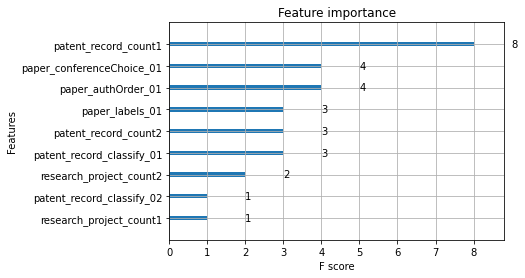

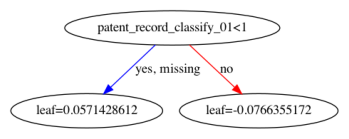

In [307]:
classifier_param = xgb.XGBClassifier(n_estimators = 25,
                            max_depth = 15,
                            learning_rate = 0.1,
                            gamma = 0.05,
                            min_child_weight = 1,
                            subsample = 1,
                            colsample_bytree = 0.2
                            )

classifier_param.fit(train_x, train_y)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_param, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier_param.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier_param)
xgb.plot_tree(classifier_param)

y_pred = classifier_param.predict(data)

print(accuracy_score(data_y, y_pred))

y_pred_xgb_gbc = classifier_param.predict_proba(test_x)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = classifier_param.predict_proba(data)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

Final CrossValMean:  0.7083333333333334
accuracy: 0.8461538461538461
0.7222222222222222
XGboost-Gradient auc:  0.5
XGboost-Gradient auc:  0.6199127906976744


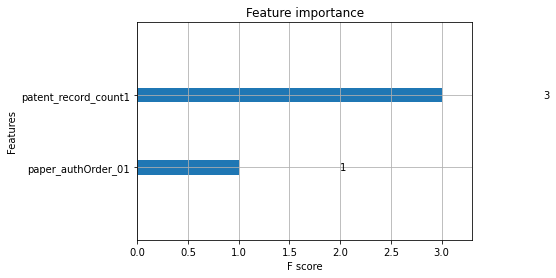

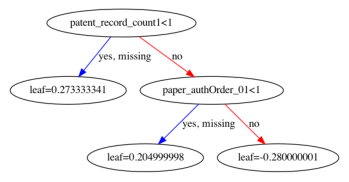

In [314]:
classifier_param_2 = xgb.XGBClassifier(n_estimators = 4,
                            max_depth = 5,
                            learning_rate = 0.41000000000000003,
                            gamma = 0.71,
                            min_child_weight = 1,
                            subsample = 0.76,
                            colsample_bytree = 0.53
                            )

classifier_param_2.fit(train_x, train_y)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_param_2, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier_param_2.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier_param_2)
xgb.plot_tree(classifier_param_2)

y_pred = classifier_param_2.predict(data)

print(accuracy_score(data_y, y_pred))

y_pred_xgb_gbc = classifier_param_2.predict_proba(test_x)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = classifier_param_2.predict_proba(data)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

traditional

Final CrossValMean:  0.7083333333333334
accuracy: 0.8461538461538461


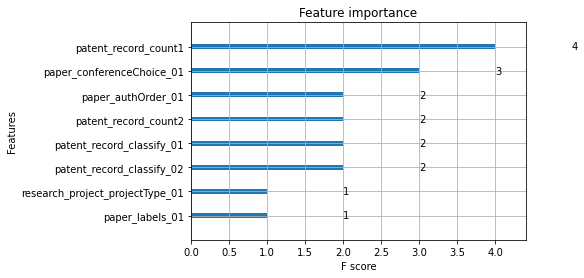

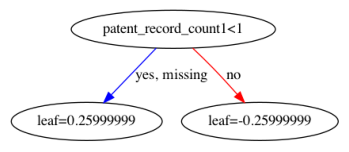

In [200]:
classifier = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier)
xgb.plot_tree(classifier)

In [201]:
y_pred = classifier.predict(data)

accuracy_score(y_pred, data_y)

0.746031746031746

In [202]:
classifier.get_booster().save_model("2-class_estimator=25_accuracy=0.746.xgb")

In [83]:
features = sorted([i for i in zip(train_x.columns, classifier.feature_importances_) if i[1] > 0], key= lambda k:k[1], reverse=True)

In [84]:
features

[('patent_record_classify_02', 0.3776298),
 ('patent_record_count1', 0.2856214),
 ('paper_conferenceChoice_01', 0.16670683),
 ('patent_record_count2', 0.06407888),
 ('patent_record_classify_01', 0.04718855),
 ('research_project_count1', 0.033656567),
 ('paper_authOrder_01', 0.025117991)]

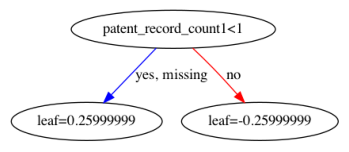

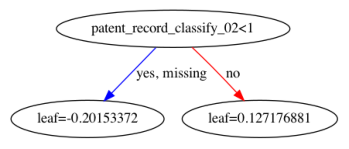

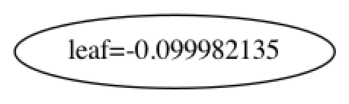

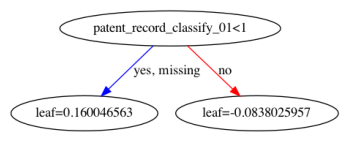

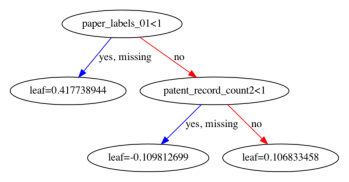

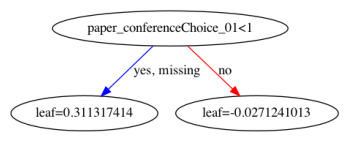

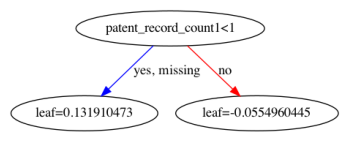

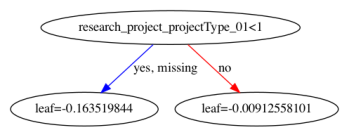

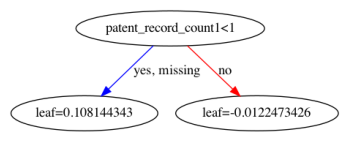

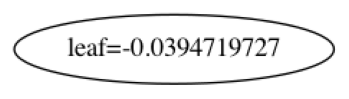

In [210]:
for i in range(0, 10):
    xgb.plot_tree(classifier, num_trees=i).figure.savefig("tree_2_accuracy_0.74_" + str(i) + ".png")

In [211]:
thresholds = np.sort(classifier.feature_importances_)

In [267]:
y_pred_xgb_gbc = classifier.predict_proba(test_x)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = classifier.predict_proba(data)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.5
XGboost-Gradient auc:  0.6322674418604651


### 构建新特征

In [69]:
from sklearn.feature_selection import SelectFromModel

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [87]:
classifier = xgb.Booster(model_file="2-class_estimator=25.xgb")

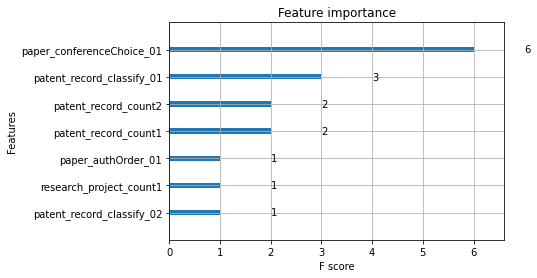

In [89]:
xgb.plot_importance(classifier)

## Logical Regression

In [1]:
xgb_enc = OneHotEncoder()
xgb_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

NameError: name 'OneHotEncoder' is not defined

In [132]:
l.shape

(113, 25)

In [125]:
df_l = pd.DataFrame(l)

col_to_del = []

In [126]:
for i in range(0, l.shape[1]):
    if len(df_l.loc[:, i].unique()) == 1:
        col_to_del.append(i)

In [127]:
col_to_del

[5, 7, 9, 11, 12, 15, 16, 18, 20, 22]

#### functionsize

In [212]:
def get_cols_del(classifier, data_set):
    l = classifier.apply(data_set)

    df_l = pd.DataFrame(l)

    col_to_del = []

    for i in range(0, l.shape[1]):
        if len(df_l.loc[:, i].unique()) == 1:
            col_to_del.append(i)

    return col_to_del

In [213]:
col_to_del = get_cols_del(classifier, train_x)

In [214]:
df_l = pd.DataFrame(classifier.apply(train_x)).drop(columns=col_to_del, axis=1)

In [215]:
df_l

,0,1,3,4,5,6,7,8,10,11,17,18,19,22,24
0,2,1,2,1,1,2,2,2,2,1,1,2,1,1,1
1,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
2,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
3,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
4,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
109,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
110,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2
111,2,1,2,3,2,2,2,2,2,1,3,2,2,2,2


In [216]:
xgb_enc.fit(df_l)

OneHotEncoder()

处理多余列

In [217]:
train_x

,paper_count1,paper_count2,paper_count3,paper_authOrder_01,paper_authOrder_02,paper_authOrder_03,paper_conferenceChoice_01,paper_conferenceChoice_02,paper_conferenceChoice_03,paper_labels_01,...,honor_title_honorRank_02,honor_title_honorRank_11,honor_title_honorRank_12,honor_title_honorRank_21,other_achievements_count1,other_achievements_count2,other_achievements_honorRank_01,other_achievements_honorRank_02,other_achievements_honorRank_11,other_achievements_honorRank_21
8,0,1,0,0,0,1,0,0,1,0,...,0,1,0,1,1,0,1,0,1,1
107,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
24,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
110,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
84,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
117,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
113,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1
105,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,1,1


In [218]:
def del_line(dataframe, col_to_del):
    return pd.DataFrame(dataframe).drop(columns=col_to_del, axis=1)

In [219]:
train_x_new = del_line(classifier.apply(train_x), col_to_del)

In [220]:
xgb_lm.fit(xgb_enc.transform(train_x_new), train_y)

LogisticRegression(max_iter=1000)

In [221]:
test_x_new = del_line(classifier.apply(test_x), col_to_del)

In [151]:
xgb_enc.transform(test_x_new)

<13x31 sparse matrix of type '<class 'numpy.float64'>'
	with 195 stored elements in Compressed Sparse Row format>

In [222]:
result = xgb_lm.predict(xgb_enc.transform(test_x_new))

In [223]:
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [224]:
test_y

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [226]:
data_new = del_line(classifier.apply(data), col_to_del)

In [227]:
result = xgb_lm.predict(xgb_enc.transform(data_new))

In [228]:
accuracy_score(result, data_y)

0.746031746031746

In [225]:
accuracy_score(result, test_y)

0.8461538461538461

##### extent features

In [229]:
train_ext = hstack([train_x, xgb_enc.transform(train_x_new)])
test_ext = hstack([test_x, xgb_enc.transform(test_x_new)])
data_ext = hstack([data, xgb_enc.transform(data_new)])

In [230]:
xgb_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [231]:
xgb_lm.fit(data_ext, data_y)

LogisticRegression(max_iter=1000)

In [232]:
xgb_lm.predict(test_ext)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [233]:
result = xgb_lm.predict(hstack([data, xgb_enc.transform(data_new)]))

In [234]:
accuracy_score(result, data_y)

0.7698412698412699

In [264]:
y_pred_xgb_gbc = xgb_lm.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = xgb_lm.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.5454545454545454
XGboost-Gradient auc:  0.6904069767441862


## Bayes

### Bernoulli Bayes

In [235]:
from sklearn.naive_bayes import BernoulliNB

In [236]:
clf_ber = BernoulliNB()
clf_ber = clf_ber.fit(data_ext, data_y)
accuracy_score(clf_ber.predict(data_ext), data_y)

0.746031746031746

In [237]:
accuracy_score(clf_ber.predict(test_ext), test_y)

0.8461538461538461

In [263]:
y_pred_xgb_gbc = clf_ber.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_ber.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.5454545454545454
XGboost-Gradient auc:  0.672093023255814


example

1

In [280]:
clf_ber = BernoulliNB()
clf_ber = clf_ber.fit(train_x, train_y)
print(accuracy_score(test_y, clf_ber.predict(test_x)))
print(accuracy_score(data_y, clf_ber.predict(data)))

0.8461538461538461
0.7619047619047619


In [282]:
y_pred_xgb_gbc = clf_ber.predict_proba(test_x)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_ber.predict_proba(data)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.45454545454545453
XGboost-Gradient auc:  0.6741279069767442


2

In [284]:
clf_ber_ext = BernoulliNB()
clf_ber_ext = clf_ber_ext.fit(train_ext, train_y)
print(accuracy_score(test_y, clf_ber_ext.predict(test_ext)))
print(accuracy_score(data_y, clf_ber_ext.predict(data_ext)))

0.8461538461538461
0.753968253968254


In [285]:
y_pred_xgb_gbc = clf_ber_ext.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_ber_ext.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.45454545454545453
XGboost-Gradient auc:  0.6726744186046512


### Gauss

In [238]:
from sklearn.naive_bayes import GaussianNB

clf_gauss = GaussianNB()
clf_gauss = clf_gauss.fit(data_ext.toarray(), data_y)
accuracy_score(clf_gauss.predict(data_ext.toarray()), data_y)

0.7698412698412699

In [262]:
y_pred_xgb_gbc = clf_gauss.predict_proba(test_ext.toarray())[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_gauss.predict_proba(data_ext.toarray())[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.5454545454545454
XGboost-Gradient auc:  0.6979651162790698


### Multinomial

In [254]:
from sklearn.naive_bayes import MultinomialNB

clf_multi = MultinomialNB()
clf_multi.fit(train_ext.toarray(), train_y)
accuracy_score(data_y, clf_multi.predict(data_ext.toarray()))

0.746031746031746

In [259]:
y_pred_xgb_gbc = clf_multi.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_multi.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.45454545454545453
XGboost-Gradient auc:  0.6729651162790697


## Gradient Boosting Classifier

In [252]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gradient = GradientBoostingClassifier()
clf_gradient.fit(train_ext, train_y)
accuracy_score(data_y, clf_gradient.predict(data_ext))

0.7698412698412699

In [292]:
clf_gradient = GradientBoostingClassifier()
clf_gradient.fit(train_ext, train_y)
accuracy_score(data_y, clf_gradient.predict(data_ext))

0.7698412698412699

In [293]:
y_pred_xgb = clf_gradient.predict_proba(test_ext)[:, 1]

print('xgboost的AUC为：' , roc_auc_score(test_y, y_pred_xgb))

y_pred_xgb_gbc = clf_gradient.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

xgboost的AUC为： 0.5454545454545454
XGboost-Gradient auc:  0.7


#### compare with pure feature -90

In [294]:
clf_gradient_pure = GradientBoostingClassifier()
clf_gradient_pure.fit(train_x, train_y)
print(accuracy_score(test_y, clf_gradient_pure.predict(test_x)))
print(accuracy_score(data_y, clf_gradient_pure.predict(data)))

0.8461538461538461
0.7698412698412699


In [335]:
y_pred_xgb = clf_gradient_pure.predict_proba(test_x)[:, 1]

print('xgboost的AUC为：' , roc_auc_score(test_y, y_pred_xgb))

y_pred_xgb_gbc = clf_gradient_pure.predict_proba(data)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

xgboost的AUC为： 0.45454545454545453
XGboost-Gradient auc:  0.6921511627906977


### ParamTuning

In [302]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='accuracy',iid=False,cv=5)
gsearch1.fit(train_ext,train_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/Users/cuichengyuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.01456194, 0.0171721 , 0.01703982, 0.02245202, 0.0261054 ,
         0.03998423, 0.03773851]),
  'std_fit_time': array([0.0029322 , 0.00301943, 0.00023321, 0.00098674, 0.0014685 ,
         0.00401163, 0.00056832]),
  'mean_score_time': array([0.00072041, 0.00055032, 0.00041738, 0.00045257, 0.00043535,
         0.00058632, 0.00059242]),
  'std_score_time': array([6.95755253e-05, 6.88093368e-05, 1.59613003e-05, 3.30064325e-05,
         3.33728104e-05, 4.48189896e-05, 7.10084660e-05]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.65217391, 0.65217391, 0.65217391, 0.65217391, 0.65217391,
         0.65

In [303]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20, min_samples_leaf=20, 
      max_features='sqrt', subsample=0.8, random_state=10), 
   param_grid = param_test2, scoring='accuracy',iid=False, cv=5)
gsearch2.fit(train_ext,train_y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/Users/cuichengyuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.0122272 , 0.01608543, 0.01074009, 0.01025143, 0.00942225,
         0.01029658, 0.01242895, 0.00972586, 0.00905137, 0.00918055,
         0.01089625, 0.01093888, 0.01283665, 0.01519485, 0.0153914 ,
         0.01527286, 0.01069455, 0.00988693, 0.01220598, 0.01761708,
         0.01680408, 0.01605463, 0.01278224, 0.01498718]),
  'std_fit_time': array([0.00133635, 0.00306175, 0.00062735, 0.0006232 , 0.0004944 ,
         0.00138285, 0.0006696 , 0.00026968, 0.00021025, 0.00038455,
         0.00057656, 0.00021132, 0.00158549, 0.00071598, 0.00059439,
         0.00138715, 0.00051007, 0.00028202, 0.00180462, 0.00245302,
         0.00123496, 0.00192563, 0.00125465, 0.00018701]),
  'mean_score_time': array([0.00059867, 0.00071445, 0.00051103, 0.00052705, 0.00041804,
         0.00050831, 0.00057769, 0.00043302, 0.0004096 , 0.00045552,
         0.0005837 , 0.0005291 , 0.00070534, 0.00071378, 0.00089402,
         0.00079398, 0.0005239 , 0.00053892, 0.00058608, 0.00095921,
  

In [305]:
param_test3 = {'min_samples_split':range(800,1900,200), 'min_samples_leaf':range(60,101,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=3,
                                     max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='accuracy',iid=False, cv=5)
gsearch3.fit(train_ext,train_y)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/Users/cuichengyuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.01266599, 0.01667895, 0.01098356, 0.00951314, 0.00954618,
         0.00902519, 0.00948758, 0.00903497, 0.00914884, 0.00908813,
         0.00986075, 0.01064301, 0.01039219, 0.01093607, 0.01218739,
         0.01096873, 0.01002007, 0.00942764, 0.01081271, 0.01056075,
         0.01267719, 0.01480517, 0.01479063, 0.01664114, 0.0178546 ,
         0.0168426 , 0.00953522, 0.01020451, 0.0093998 , 0.00996222]),
  'std_fit_time': array([1.03048595e-03, 2.64696315e-03, 7.25510840e-04, 4.24934310e-04,
         6.20124801e-04, 9.14987763e-05, 3.96501563e-04, 8.20094206e-05,
         2.15963755e-04, 1.13526466e-04, 9.85354053e-04, 3.15567034e-04,
         1.43416336e-04, 2.92190831e-04, 1.17391609e-03, 4.03660395e-04,
         2.73232327e-04, 3.33628944e-04, 1.16356849e-03, 8.73382064e-04,
         1.18692919e-03, 9.83579701e-04, 9.01845328e-04, 1.70590542e-03,
         1.29281614e-03, 6.01467118e-03, 3.00781554e-04, 1.07962709e-03,
         2.56029434e-04, 1.33212600e-04]

In [306]:
gbm1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=3, min_samples_leaf =60, 
               min_samples_split =800, max_features='sqrt', subsample=0.8, random_state=10)
gbm1.fit(train_ext,train_y)
y_pred = gbm1.predict(data_ext)
y_predprob = gbm1.predict_proba(data_ext)[:,1]
print("Accuracy : %.4g" % accuracy_score(data_y, y_pred))
print("AUC Score (Train): %f" % roc_auc_score(data_y, y_predprob))

Accuracy : 0.6825
AUC Score (Train): 0.500000


In [327]:
from numpy.random import RandomState

import hyperopt

import warnings

def hyperopt_objective_gradient(params):
    
#     warnings.filter("ignore")
    
    model = GradientBoostingClassifier(
                            n_estimators = int(params['n_estimators']),
                            max_depth = int(params['max_depth']),
                            learning_rate = params['learning_rate'],
                            min_samples_split= params['min_samples_split'],
                            subsample = params['subsample'],
                            )
     
    metric = cross_val_score(model, train_x, train_y, cv=5, scoring="accuracy")
    
    return np.max(metric) # as hyperopt minimises

params_space = {
    'max_depth' : hp.choice('max_depth', range(1, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'min_samples_split' : hp.quniform('min_samples_split', 0.01, 1, 0.01),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
}

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective_gradient,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

100%|██████████| 100/100 [00:23<00:00,  4.19trial/s, best loss: 0.6818181818181818]

展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换
{'learning_rate': 0.47000000000000003, 'max_depth': 9, 'min_samples_split': 0.8200000000000001, 'n_estimators': 20, 'subsample': 0.15}


In [337]:
classifier_gradient_tune = GradientBoostingClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            min_samples_split = best['min_samples_split'],
                            subsample = best['subsample'],
                            )

classifier_gradient_tune.fit(train_ext, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_gradient_tune, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier_gradient_tune.predict(test_ext)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))

Final CrossValMean:  0.6636363636363637
accuracy: 0.8461538461538461


In [338]:
y_pred = classifier_gradient_tune.predict(data_ext)
accuracy_score(data_y, y_pred)

0.6825396825396826

In [339]:
y_pred_xgb = classifier_gradient_tune.predict_proba(test_ext)[:, 1]

print('xgboost的AUC为：' , roc_auc_score(test_y, y_pred_xgb))

y_pred_xgb_gbc = classifier_gradient_tune.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

xgboost的AUC为： 0.5
XGboost-Gradient auc:  0.5


### Extend model param fine-tuning

In [341]:
from numpy.random import RandomState

import hyperopt

import warnings

def hyperopt_objective_gradient(params):
    
#     warnings.filter("ignore")
    
    model = GradientBoostingClassifier(
                            n_estimators = int(params['n_estimators']),
                            max_depth = int(params['max_depth']),
                            learning_rate = params['learning_rate'],
                            min_samples_split= params['min_samples_split'],
                            subsample = params['subsample'],
                            )
     
    metric = cross_val_score(model, train_ext, train_y, cv=5, scoring="roc_auc")
    
    return np.max(metric) # as hyperopt minimises

params_space = {
    'max_depth' : hp.choice('max_depth', range(1, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'min_samples_split' : hp.quniform('min_samples_split', 0.01, 1, 0.01),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
}

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective_gradient,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

 99%|█████████▉| 99/100 [00:30<00:00,  3.24trial/s, best loss: 0.5] 


KeyboardInterrupt: 

In [334]:
classifier_gradient_tune = GradientBoostingClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            min_samples_split = best['min_samples_split'],
                            subsample = best['subsample'],
                            )

classifier_gradient_tune.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_gradient_tune, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier_gradient_tune.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))

y_pred = classifier_gradient_tune.predict(data)
accuracy_score(data_y, y_pred)

Final CrossValMean:  0.6636363636363637
accuracy: 0.8461538461538461


0.6825396825396826

In [323]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## SVM

In [249]:
from sklearn.svm import SVC

In [269]:
clf_svc = SVC(probability=True)
clf_svc.fit(data_ext, data_y)
accuracy_score(clf_svc.predict(data_ext), data_y)

0.746031746031746

In [270]:
y_pred_xgb_gbc = clf_svc.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_svc.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.45454545454545453
XGboost-Gradient auc:  0.657267441860465


### Decision Tree

In [274]:
from sklearn.tree import DecisionTreeClassifier

In [275]:
clf_tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)

dt_clf_tree = clf_tree.fit(train_x, train_y)

accuracy_score(data_y, dt_clf_tree.predict(data))

0.746031746031746

In [277]:
clf_tree_ext = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)

dt_clf_tree_ext = clf_tree_ext.fit(train_ext, train_y)

accuracy_score(data_y, dt_clf_tree_ext.predict(data_ext))

0.746031746031746

In [278]:
y_pred_xgb_gbc = clf_tree_ext.predict_proba(test_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(test_y, y_pred_xgb_gbc))

y_pred_xgb_gbc = clf_tree_ext.predict_proba(data_ext)[:, 1]

print("XGboost-Gradient auc: ", roc_auc_score(data_y, y_pred_xgb_gbc))

XGboost-Gradient auc:  0.5
XGboost-Gradient auc:  0.6382267441860465
